In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from micrograd.engine import Value
from sklearn.datasets import make_moons
from micrograd.nn import Neuron, Layer, MLP
%matplotlib inline

In [2]:
dataset_path = r"C:\Users\chand\Desktop\datasets\cleaned_data.csv"

df = pd.read_csv(dataset_path)
df.dropna(axis=0, inplace=True)
df.drop('location', axis=1, inplace=True)
new_order = ['total_sqft', 'bath', 'BHK', 'price']
df = df[new_order]
df.head(20)

,total_sqft,bath,BHK,price
0,1056.0,2.0,2,39.07
1,2600.0,5.0,4,120.00
2,1440.0,2.0,3,62.00
3,1521.0,3.0,3,95.00
4,1200.0,2.0,2,51.00
5,1170.0,2.0,2,38.00
6,2732.0,4.0,4,204.00
7,1310.0,3.0,3,63.25
8,1020.0,6.0,6,370.00
9,1800.0,2.0,3,70.00


In [3]:
X = np.array(df.iloc[:, :3].values)[:100]
y = np.array(df.iloc[:,3:].values.flatten())[:100]

In [4]:
# initialinze the model for simple linear regression

model = MLP(3, [16,16,1])
print(model)
print(f'Number of parameters: {len(model.parameters())}')

MLP of [Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Number of parameters: 353


In [8]:
def zScoreNormalization(data):
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    normalized_data = (data - mean) / std_dev
    return normalized_data

def dataLoader(batch_size=None, X=list, y=list):
    # data loader
    if batch_size is None:
            Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    # convert all inputs into Value objects
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    return inputs, yb

def forwardPass(inputs):
    return list(map(model, inputs))

# loss function
def lossFunctions(X, y, loss_type):

    # MSE error
    def MSELoss():
        squared_diffs = [(yhat_i - yi) ** 2 for yhat_i, yi in zip(X, y)]
        mse = sum(squared_diffs) / (2 * len(X))
        return mse

    # SVM margin loss
    def SVMLoss():
        losses = [(1 + -yi*scorei).relu() for scorei, yi in zip(X, y)]
        data_loss = sum(losses) * (1.0 / len(losses))
        return data_loss
    
    def L2Regularization():
        alpha = 1e-4
        reg_loss = alpha * sum((p*p for p in model.parameters()))
        total_loss = (MSELoss() if loss_type == 'MSE' else SVMLoss()) + reg_loss
        return total_loss
    
    total_loss = L2Regularization()
    return total_loss

def accuracyRegression(X,y):
    y_mean = np.mean(y)
    total_sum_squares = np.sum((y - y_mean) ** 2)
    residual_sum_squares = np.sum((y - X) ** 2)
    r_squared = 1 - (residual_sum_squares / total_sum_squares)
    return r_squared

def accuracyClassification(X, y):
    accuracy = [(yi > 0) == (scorei.data > 0) for scorei, yi in zip(X, y)]
    return sum(accuracy) / len(accuracy)

In [6]:
# normalize X and y
X, y = zScoreNormalization(X), zScoreNormalization(y)

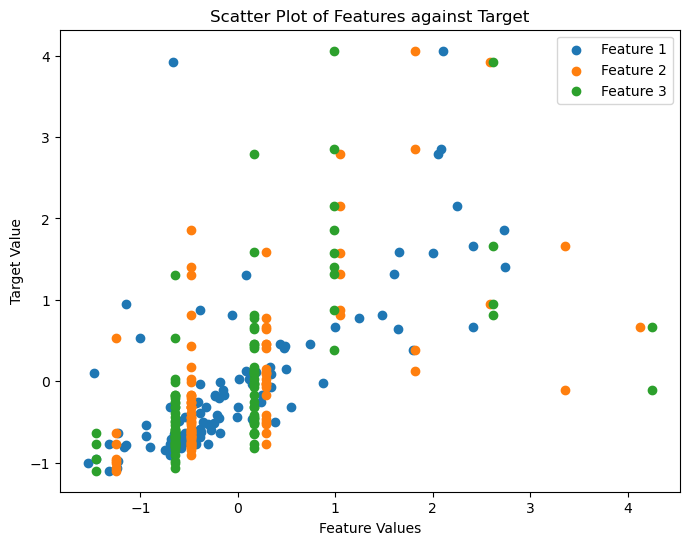

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(3):
    ax.scatter(X[:, i], y, label=f'Feature {i+1}')

ax.set_xlabel('Feature Values')
ax.set_ylabel('Target Value')
ax.set_title('Scatter Plot of Features against Target')
ax.legend()

plt.show()

In [8]:
# optimization for regression task
for k in range(30):
    inputs, y = dataLoader(batch_size=None, X=X, y=y)
    X_fp = forwardPass(inputs)
    total_loss = lossFunctions(X_fp, y, 'MSE')
    acc = accuracyRegression(X_fp, y)

    # backprop
    model.zero_grad()
    total_loss.backward()

    # gradient descent
    learning_rate = 0.01
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"Step {k}, Loss: {total_loss.data}, R-squared: {acc.data}")

Step 0, Loss: 9.40446268735, R-squared: -17.78718324452277
Step 1, Loss: 2.965007175015599, R-squared: -4.908498370208084
Step 2, Loss: 1.5559238552710584, R-squared: -2.0904061983352693
Step 3, Loss: 0.9940719932403509, R-squared: -0.966740396653885
Step 4, Loss: 0.7292146139943172, R-squared: -0.43704798959508295
Step 5, Loss: 0.5927349805459918, R-squared: -0.1641032253518626
Step 6, Loss: 0.5170343757054856, R-squared: -0.012712179069352958
Step 7, Loss: 0.4707304843542277, R-squared: 0.07988799921242329
Step 8, Loss: 0.43963518093887965, R-squared: 0.1420726131491069
Step 9, Loss: 0.4172484397279349, R-squared: 0.18684118928268023
Step 10, Loss: 0.3998991750908449, R-squared: 0.22153557068760432
Step 11, Loss: 0.3858175700516137, R-squared: 0.2496951862473079
Step 12, Loss: 0.3740300352323466, R-squared: 0.2732670827455014
Step 13, Loss: 0.3638645963413313, R-squared: 0.29359510985674553
Step 14, Loss: 0.35514262133656377, R-squared: 0.31103646559756926
Step 15, Loss: 0.3477841719

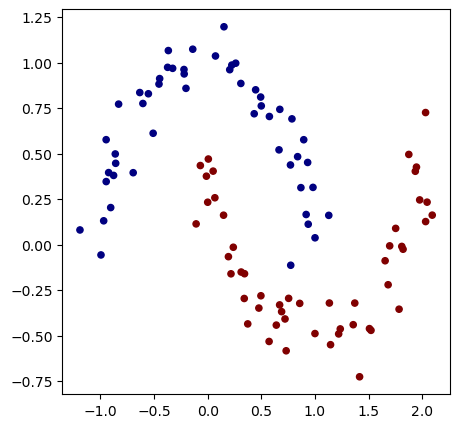

In [9]:
# classification
X, y = make_moons(n_samples=100, noise=0.1)
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [10]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [12]:
# optimization for classification task
for k in range(100):
    inputs, y = dataLoader(batch_size=None, X=X, y=y)
    X_fp = forwardPass(inputs)
    total_loss = lossFunctions(X_fp, y, 'SVM')
    acc = accuracyClassification(X_fp, y)

    # backprop
    model.zero_grad()
    total_loss.backward()

    # gradient descent
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.7362927345486778, accuracy 43.0%
step 1 loss 0.7289319581721129, accuracy 59.0%
step 2 loss 0.5251404311383505, accuracy 74.0%
step 3 loss 0.44021672374929305, accuracy 83.0%
step 4 loss 0.6048657166197124, accuracy 79.0%
step 5 loss 0.30813638076877037, accuracy 85.0%
step 6 loss 0.2750843797886583, accuracy 87.0%
step 7 loss 0.2514167800000894, accuracy 87.0%
step 8 loss 0.23543618014962023, accuracy 91.0%
step 9 loss 0.22252896046252144, accuracy 90.0%
step 10 loss 0.21473542034472073, accuracy 93.0%
step 11 loss 0.2454944613200572, accuracy 89.0%
step 12 loss 0.3923897197837703, accuracy 89.0%
step 13 loss 0.26715318010401207, accuracy 87.0%
step 14 loss 0.2543404052501882, accuracy 91.0%
step 15 loss 0.19903819450926935, accuracy 94.0%
step 16 loss 0.19735204345927426, accuracy 94.0%
step 17 loss 0.21452433482067296, accuracy 92.0%
step 18 loss 0.3980769608947737, accuracy 89.0%
step 19 loss 0.18183385074762376, accuracy 92.0%
step 20 loss 0.16480026435404804, accura

(-1.7256996369147457, 2.0243003630852545)

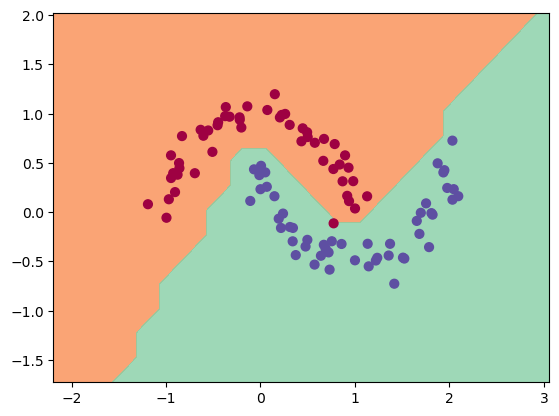

In [13]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
